# 00. Import packakes

In [1]:
import numpy as np
import ase
import abtem
import matplotlib.pyplot as plt
from datetime import datetime
from tifffile import imwrite
import os
import dask
import cupy as cp
from cupyx.scipy import ndimage
abtem.config.set({"local_diagnostics.progress_bar": True})
abtem.config.set({"device": "gpu"})
abtem.config.set({"dask.chunk-size-gpu" : "512 MB"})
dask.config.set({"num_workers": 1})



# 01. Build frozen phonon potential

In [ ]:
# Set up random seed
np_seed = 42

# Atomic model
mx2_formula = 'WSe2'
mx2_phase = '2H'
lattice_constant = 3.297
uc_thickness = 3.376
vacuum_layers = 2
supercell_reps = (13, 7, 1)#(38, 22, 1)

# Phonon
num_phonon_configs = 256 # target value: 25
phonon_sigma = 0.1 # Ang

# Potential Sampling
real_space_sampling = 0.08 # unit: Ang, note that kmax_antialias = 1/(3*dx), so if we want to simulate up to kmax = 4.1 1/Ang, we need 1/4.1/3 Ang sampling or slightly finer ~ 0.08 Ang 
dz = 1 # Ang, multislice thickness

# Output directory
output_dir = 'output/abtem'
os.makedirs(output_dir, exist_ok = True)

In [ ]:
atoms = ase.build.mx2(formula=mx2_formula, kind=mx2_phase, a=lattice_constant, thickness=uc_thickness, vacuum=vacuum_layers) # a: lattice constant, thickness: chalcogen intralayer distance, vacuum = vacuum layer thickness. All unit in Ang.
atoms_sc = abtem.orthogonalize_cell(atoms) * supercell_reps # lx:ly = 1:sqrt(3)
print(f'atoms_sc.cell = {atoms_sc.cell} Ang') # Unit: Ang

# Include frozen phonon configuration
np.random.seed(np_seed)
phonon_seed = np.random.randint(0,1000, num_phonon_configs)
frozen_phonons = abtem.FrozenPhonons(atoms_sc, num_configs=num_phonon_configs, sigmas=phonon_sigma, seed = phonon_seed) # sigmas is in unit of Ang.
print(f'phonon_seed = {phonon_seed}')

potential_static = abtem.Potential(atoms_sc,       sampling = real_space_sampling, slice_thickness=dz)
potential_phonon = abtem.Potential(frozen_phonons, sampling = real_space_sampling, slice_thickness=dz)
print(f'potential_static.shape = {potential_static.shape}')
print(f'potential_phonon.shape = {potential_phonon.shape}')

In [ ]:
potential_phonon.build().array

potential_phonon_zsum = np.sum(potential_phonon.build().compute().array.get(), axis=1)
imwrite(os.path.join(output_dir, f'potential_{num_phonon_configs}_phonon_{phonon_sigma}_std_zsum_dx{real_space_sampling}Ang.tif'), potential_phonon_zsum)

# potential_phonon_sum = np.mean(np.sum(potential_phonon.build().compute().array.get(), axis=1), axis=0)
# imwrite(os.path.join(output_dir, 'potential_phonon_sum_dx0.08Ang.tif'), potential_phonon_sum)

# potential_static_sum = np.sum(potential_static.build().compute().array.get(), axis=0)
# imwrite(os.path.join(output_dir, 'potential_static_sum_dx0.08Ang.tif'), potential_static_sum)

# Simulate CBED with different frozen phonon configurations

In [ ]:
probe = abtem.Probe(energy=80e3, semiangle_cutoff=20, defocus=-200) # negative value for overfocus
probe.grid.match(potential_phonon)

In [ ]:
probe.build().compute().show()

In [ ]:
cbeds = probe.multislice(potential_phonon).diffraction_patterns().compute().array

In [ ]:
short_side = min(cbeds.shape[-1],cbeds.shape[-2])
long_side = max(cbeds.shape[-1],cbeds.shape[-2])
zoom_factor = (1, long_side/cbeds.shape[-2], long_side/cbeds.shape[-1])
cbeds_reshape = ndimage.zoom(cbeds, zoom_factor, order=1)
print(cbeds_reshape.shape)

In [ ]:
imwrite(os.path.join(output_dir, f"cbed_{num_phonon_configs}_phonon_{phonon_sigma}_std_zsum_dx{real_space_sampling}Ang.tif"), cbeds_reshape.get())

# 02. Build multi object state 4D-STEM

In [15]:
# Atomic model
mx2_formula = 'WSe2'
mx2_phase = '2H'
lattice_constant = 3.297
uc_thickness = 3.376
vacuum_layers = 2
supercell_reps = (13, 7, 1)

# Potential Sampling
real_space_sampling = 0.08 # unit: Ang, note that kmax_antialias = 1/(3*dx), so if we want to simulate up to kmax = 4.1 1/Ang, we need 1/4.1/3 Ang sampling or slightly finer ~ 0.08 Ang 
dz = 1 # Ang, multislice thickness

# Output directory
output_dir = 'output/abtem/multi_object'
os.makedirs(output_dir, exist_ok = True)

atom1 = ase.build.mx2(formula=mx2_formula, kind=mx2_phase, a=lattice_constant, thickness=uc_thickness, vacuum=vacuum_layers) # a: lattice constant, thickness: chalcogen intralayer distance, vacuum = vacuum layer thickness. All unit in Ang.
atom1_sc = abtem.orthogonalize_cell(atom1) * supercell_reps # lx:ly = 1:sqrt(3)
print(f'atom1_sc.cell = {atom1_sc.cell} Ang') # Unit: Ang

from ase.build import bulk

supercell_reps = (12,9,3)
(a,b,c) = atom1_sc.cell / np.array(supercell_reps)

atom2 = ase.build.bulk('Cu', 'orthorhombic', a=a, b=b, c=c, orthorhombic=True)
atom2_sc = atom2 * supercell_reps
print(f'atom2_sc.cell = {atom2_sc.cell} Ang') # Unit: Ang


atom1_sc.cell = Cell([42.861000000000004, 39.97400058788212, 7.3759999999999994]) Ang
atom2_sc.cell = Cell([42.861000000000004, 39.97400058788212, 7.3759999999999994]) Ang


(<Figure size 640x480 with 1 Axes>,
 <AxesSubplot:xlabel='x [Å]', ylabel='y [Å]'>)

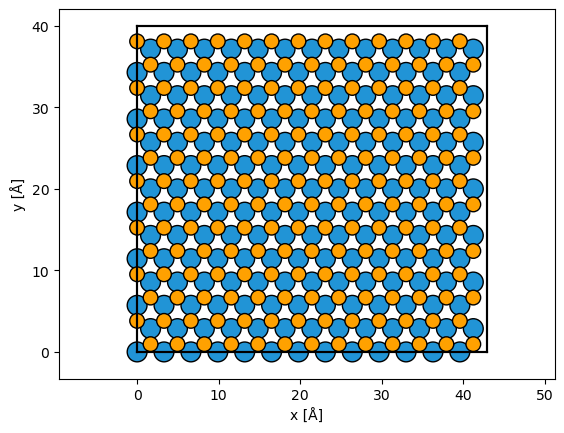

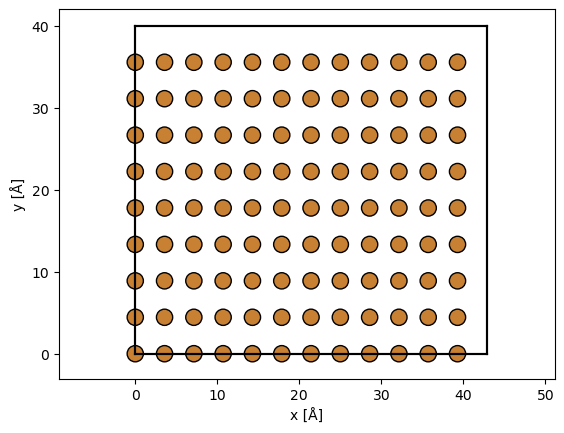

In [16]:
abtem.show_atoms(atom1_sc)
abtem.show_atoms(atom2_sc)

potential_1.shape = (8, 536, 500)
potential_2.shape = (8, 536, 500)
[########################################] | 100% Completed | 223.99 ms


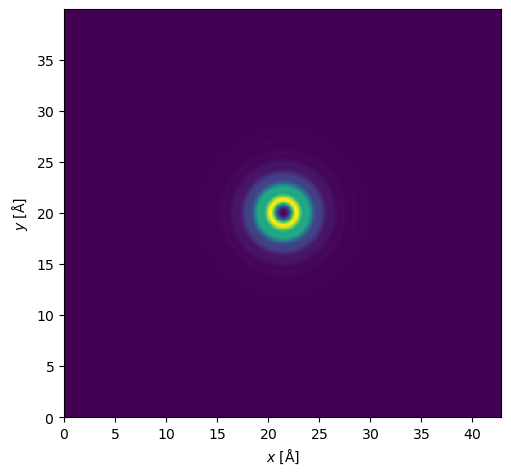

In [17]:
potential_1 = abtem.Potential(atom1_sc,       sampling = real_space_sampling, slice_thickness=dz)
print(f'potential_1.shape = {potential_1.shape}')

potential_2 = abtem.Potential(atom2_sc,       sampling = real_space_sampling, slice_thickness=dz)
print(f'potential_2.shape = {potential_2.shape}')

probe = abtem.Probe(energy=80e3, semiangle_cutoff=20, defocus=-200) # negative value for overfocus
probe.grid.match(potential_1)
probe.build().compute().show()

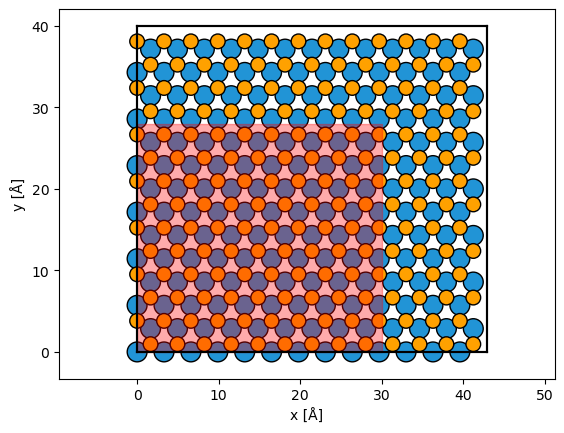

In [18]:
scan_step_size = 0.3 # Ang
grid_scan = abtem.GridScan(
    start=[0, 0],
    end=[0.7, 0.7],
    sampling=scan_step_size,
    fractional=True,
    potential=potential_1,
)

fig, ax = abtem.show_atoms(atom1_sc)
grid_scan.add_to_plot(ax)

In [29]:
print(grid_scan.get_positions().shape)
grid_scan.get_positions()[:10,0]

(101, 94, 2)


array([[0.        , 0.        ],
       [0.29705644, 0.        ],
       [0.5941129 , 0.        ],
       [0.8911693 , 0.        ],
       [1.1882257 , 0.        ],
       [1.4852822 , 0.        ],
       [1.7823386 , 0.        ],
       [2.079395  , 0.        ],
       [2.3764515 , 0.        ],
       [2.673508  , 0.        ]], dtype=float32)

In [31]:
print(grid_scan.get_positions().reshape(-1,2).shape)
grid_scan_pos = grid_scan.get_positions().reshape(-1,2)
grid_scan_pos[:10]


(9494, 2)


array([[0.        , 0.        ],
       [0.        , 0.29767874],
       [0.        , 0.5953575 ],
       [0.        , 0.8930362 ],
       [0.        , 1.190715  ],
       [0.        , 1.4883937 ],
       [0.        , 1.7860724 ],
       [0.        , 2.0837512 ],
       [0.        , 2.38143   ],
       [0.        , 2.6791086 ]], dtype=float32)

In [45]:
import h5py
ppX = grid_scan_pos[:,1]
ppY = grid_scan_pos[:,0]
ppX = ppX - ppX.mean()
ppY = ppY - ppY.mean()
with h5py.File('output/abtem/20240328_multi_object/scan_position.hdf5', 'w') as hdf_file:
    hdf_file.create_dataset('/ppX', data = ppX)
    hdf_file.create_dataset('/ppY', data = ppY)

In [ ]:
#cbeds1 = probe.multislice(scan = grid_scan, potential = potential_1).diffraction_patterns().compute().array
#cbeds2 = probe.multislice(scan = grid_scan, potential = potential_2).diffraction_patterns().compute().array

In [ ]:
#imwrite(os.path.join(output_dir, "cbed_WSe2_fov_42p86_39p97.tif"), cbeds1.get())
#imwrite(os.path.join(output_dir, "cbed_Cu_fov_42p86_39p97.tif"), cbeds2.get())

# Postprocessing

In [3]:
from tifffile import imread
output_dir = 'output/abtem/multi_object'


In [4]:
cbeds1 = imread("output/abtem/multi_object/cbed_WSe2_fov_42p86_39p97.tif")
cbeds1.shape

(101, 94, 359, 335)

In [38]:
#cbeds1_reshape = ndimage.zoom(cp.array(cbeds1), (1,1,180/359,180/335), order=1)
#imwrite(os.path.join(output_dir, "cbed_WSe2_fov_42p86_39p97_dp180.tif"), cbeds1_reshape.get())
file_path = os.path.join(output_dir, "cbed_WSe2_fov_42p86_39p97_dp180")
with h5py.File(file_path + '.hdf5', 'w') as hf:
    hf.create_dataset('/dp', data = cbeds1_reshape.reshape(-1,180,180).get())

In [10]:
cbeds2 = imread("output/abtem/multi_object/cbed_Cu_fov_42p86_39p97.tif")
cbeds2.shape

In [39]:
#cbeds2_reshape = ndimage.zoom(cp.array(cbeds2), (1,1,180/359,180/335), order=1)
#imwrite(os.path.join(output_dir, "cbed_Cu_fov_42p86_39p97_dp180.tif"), cbeds2_reshape.get())
file_path = os.path.join(output_dir, "cbed_Cu_fov_42p86_39p97_dp180")
with h5py.File(file_path + '.hdf5', 'w') as hf:
    hf.create_dataset('/dp', data = cbeds2_reshape.reshape(-1,180,180).get())

In [40]:
#imwrite(os.path.join(output_dir, "cbed_WSe2_and_Cu_fov_42p86_39p97_dp180.tif"), ((cbeds1_reshape + cbeds2_reshape)/2).get())
file_path = os.path.join(output_dir, "cbed_WSe2_and_Cu_fov_42p86_39p97_dp180")
with h5py.File(file_path + '.hdf5', 'w') as hf:
    hf.create_dataset('/dp', data = ((cbeds1_reshape + cbeds2_reshape)/2).reshape(-1,180,180).get())